In [1]:
!pip install city2graph

In [4]:
!pip install torch torch_geometric networkx shapely

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 MB 21.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14/14 [torch_geometric] [torch_geometric]


In [1]:
import geopandas as gpd 
import osmnx as ox 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D 
from matplotlib.animation import FuncAnimation 
import city2graph as c2g

/Users/megnath/miniforge3/envs/mcp-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download and project the street network to British National Grid (EPSG:27700) for metric distances
# Data should be obtained from Only in Soho, London
G = ox.graph_from_place(
    "Soho, London",
    network_type="all",
)

In [3]:
street_primary_nodes, street_primary_edges = c2g.nx_to_gdf(G)
street_primary_nodes = street_primary_nodes.to_crs(epsg=27700)
street_primary_edges = street_primary_edges.to_crs(epsg=27700)

amenity_tags = ["cafe", "restaurant", "pub", "bar", "museum", "theatre", "cinema"]
amenity_candidates = ox.features_from_place(
    "Soho, London",
    tags={"amenity": amenity_tags},
).to_crs(epsg=27700)

In [4]:
# Collapse complex Amenity geometries to points within the projected CRS 
amenities = ( 
    amenity_candidates[["name", "amenity", "geometry"]] 
    .copy() 
    .explode(index_parts=False) 
    .dropna(subset=["geometry"]) 
    ) 

non_point_mask = ~amenities.geometry.geom_type.isin(["Point"]) 
amenities.loc[non_point_mask, "geometry"] = amenities.loc[non_point_mask, "geometry"].centroid 
amenities = amenities.set_geometry("geometry") 
amenities["name"] = amenities["name"].fillna(amenities["amenity"].str.title()) 
amenities = amenities[~amenities.geometry.is_empty] 
amenities = amenities.drop_duplicates(subset="geometry").reset_index(drop=True)

In [6]:
# Display street network data 
print("Street Primary Nodes:") 
display(street_primary_nodes.head(3)) 
print("\nStreet Primary Edges:") 
display(street_primary_edges.head(3)) 
print("\nAmenities:") 
display(amenities.head(3))

Street Primary Nodes:


,y,x,street_count,geometry,highway,railway,ref
107324,51.515651,-0.132443,4,POINT (529683.159 181289.359),NaN,NaN,NaN
107326,51.515148,-0.132727,4,POINT (529664.875 181232.921),NaN,NaN,NaN
107328,51.514837,-0.132323,3,POINT (529693.803 181199.041),NaN,NaN,NaN



Street Primary Edges:


osmid      highway maxspeed         name  oneway  \
107324 12437701118 0   59207650  residential   20 mph  Soho Street   False   
       11310505522 0  395757466      footway      NaN          NaN   False   
       1694551556  0    4082521  residential   20 mph  Soho Square    True   

                     reversed     length  \
107324 12437701118 0    False   8.366709   
       11310505522 0    False   6.567612   
       1694551556  0    False  74.927392   

                                                               geometry lanes  \
107324 12437701118 0  LINESTRING (529683.159 181289.359, 529679.695 ...   NaN   
       11310505522 0  LINESTRING (529683.159 181289.359, 529684.78 1...   NaN   
       1694551556  0  LINESTRING (529683.159 181289.359, 529706.44 1...   NaN   

                     access width tunnel service  
107324 12437701118 0    NaN   NaN    NaN     NaN  
       11310505522 0    NaN   NaN    NaN     NaN  
       1694551556  0    NaN   NaN    NaN     NaN


Amenities:


,name,amenity,geometry
0,Curzon Soho,cinema,POINT (529818.965 180959.788)
1,Pastaio,restaurant,POINT (529233.765 180972.225)
2,Yauatcha,restaurant,POINT (529498.558 181064.047)


<Axes: >

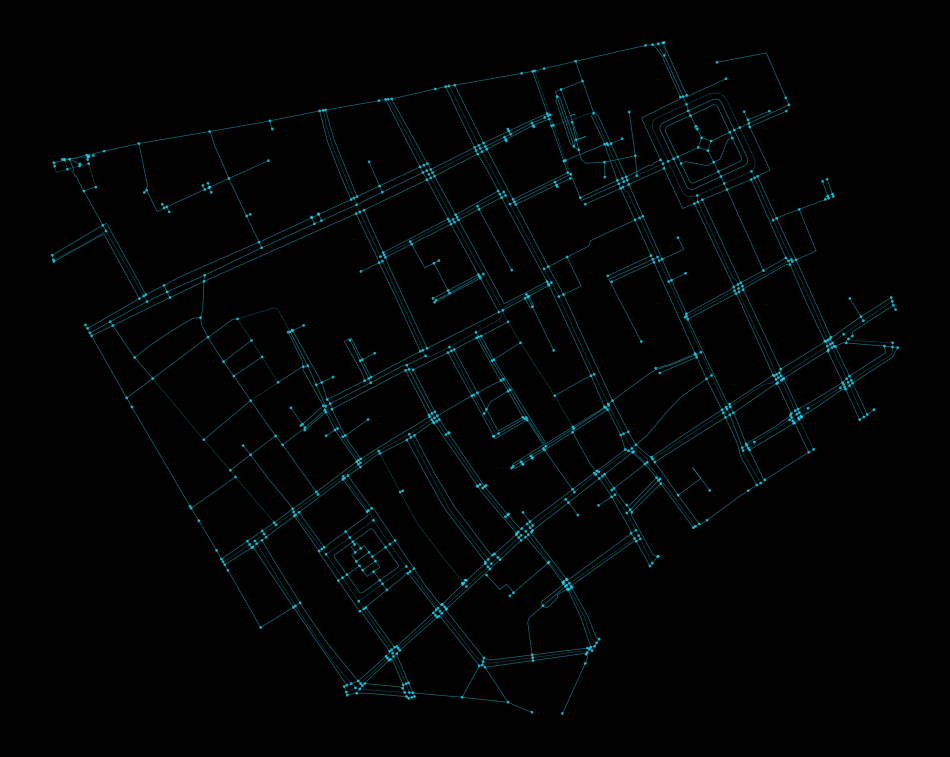

In [7]:
c2g.plot_graph(nodes=street_primary_nodes, edges=street_primary_edges)